In [1]:
import numpy as np

import stan
import nest_asyncio
import asyncio

# Apply this patch to allow nested use of asyncio.run()
nest_asyncio.apply()

In [2]:
# Load calibrated design matrix and observation
# design matrix:
#   - 1st column: Stimulus (calibrated)
#   - 2nd column: Coherence
#   - 3rd column: Attention
#   - 4th column: Expectation (calibrated)
design_matrix = np.load("../analysis/cache/exp_design.npy")
observation = np.load("../analysis/cache/exp_obs.npy")

design_matrix.shape, observation.shape

((260, 120, 4), (260, 120, 1))

In [3]:
design_matrix = np.nan_to_num(design_matrix)
observation = np.nan_to_num(observation)

# Convert to radians
design_matrix[:,:,0] = np.deg2rad(design_matrix[:,:,0])
design_matrix[:,:,3] = np.deg2rad(design_matrix[:,:,3])

observation = np.deg2rad(observation)

# Coherence
design_matrix[:,:,1][design_matrix[:,:,1] == 1] = -1
design_matrix[:,:,1][design_matrix[:,:,1] == 2] = 1

# Attention
design_matrix[:,:,2][design_matrix[:,:,2] == 1] = -1
design_matrix[:,:,2][design_matrix[:,:,2] == 2] = 1

# Shuffle data
shuff_idx = np.random.permutation(len(design_matrix))

design_matrix = design_matrix[shuff_idx]
observation = observation[shuff_idx]

x_tr = design_matrix[:,:,1:]
x_em = design_matrix[:,:,0]



In [4]:
x_tr.shape, x_em.shape, observation.shape

((260, 120, 3), (260, 120), (260, 120, 1))

In [5]:
# code = """
# data {
#   int<lower=1> K;  // Number of latent states
#   int<lower=0> T;  // Number of time points

#   vector[2] wmu;
#   vector[2] tau;

#   array[T] real<lower=-pi(), upper=pi()> y;  // Observed circular emissions
#   array[T] int<lower=1, upper=K> z;  // Observed latent states

#   vector<lower=0>[K] pi_init;  // Initial distribution over states

#   array[T] vector[3] x_tr;  // External inputs for transitions
#   array[T] real x_em;  // External inputs for emission
# }
# parameters {
#   // Transition coefficients
#   array[K] real a;
#   array[K] vector[3] b;  // Transition weights
# }

# model {
#   // Priors for transition weights and emissions
#   for (k in 1:K) {
#     a[k] ~ normal(0, 1);
#     b[k] ~ normal(0, 1);
#   }

#   // Initial state
#   z[1] ~ categorical(pi_init);

#   // Observed data model
#   for (t in 1:T) {

#     // Compute mean direction (mu)
#     real mu = wmu[z[t]] * x_em[t];
#     y[t] ~ von_mises(mu, tau[z[t]]);

#     if (t < T) {
#       // Compute eta for transitions from state z[t]
#       vector[K] eta;
#       for (k in 1:K) {
#         eta[k] = dot_product(b[k], x_tr[t]) + a[k];
#       }
#       // Transition to next state
#       z[t + 1] ~ categorical_logit(eta);
#     }
#   }
# }
# """

In [6]:
code = """

data {
  int<lower=1> K;  // Number of latent states
  int<lower=0> T;  // Number of time points per trial
  int<lower=1> J;  // Number of trials

  vector[2] wmu;
  vector[2] tau;

  array[J, T] real<lower=-2*pi(), upper=2*pi()> y;  // Observed circular emissions for each trial
  array[J, T] int<lower=1, upper=K> z;  // Observed latent states for each trial

  vector<lower=0>[K] pi_init;  // Initial distribution over states

  array[J, T] vector[3] x_tr;  // External inputs for transitions for each trial
  array[J, T] real x_em;  // External inputs for emission for each trial
}
parameters {
  // Transition coefficients
  array[K] real a;
  array[K] vector[3] b;  // Transition weights
}
model {
  // Priors for transition weights and emissions
  for (k in 1:K) {
    a[k] ~ normal(0, 1);
    b[k] ~ normal(0, 1);
  }

  // Loop over trials
  for (j in 1:J) {
    // Initial state for each trial
    z[j, 1] ~ categorical(pi_init);

    // Observed data model for each trial
    for (t in 1:T) {
      // Compute mean direction (mu)
      real mu = wmu[z[j, t]] * x_em[j, t];
      y[j, t] ~ von_mises(mu, tau[z[j, t]]);

      if (t < T) {
        // Compute eta for transitions from state z[j, t]
        vector[K] eta;
        for (k in 1:K) {
          eta[k] = dot_product(b[k], x_tr[j, t]) + a[k];
        }
        // Transition to next state
        z[j, t + 1] ~ categorical_logit(eta);
      }
    }
  }
}


"""

In [7]:
# Define parameters
J = 10
T = 120  # Number of time points
K = 2  # Number of latent states

wmu = [1, 0.1]
tau = [6, 0.5]

# Create observed circular emissions (randomly for now, replace with actual data as needed)
# y = np.random.vonmises(2.5, 1, (T))
y = observation.squeeze()[:J]

# Create observed latent states (placeholder; should be hidden in real scenarios)
z = np.random.randint(1, K + 1, (J,T))

# Initial distribution over states
pi_init = np.random.dirichlet([1.0] * K)

# External inputs for transitions (random data for demo; replace with actual data)
x_tr = x_tr[:J]
x_em = x_em[:J]

# Data dictionary for Stan
hmm_data = {
    "K": K,
    "T": T,
    "J": J,
    "wmu": wmu,
    "tau": tau,
    "y": y,
    "z": z,
    "pi_init": pi_init,
    "x_tr": x_tr,
    "x_em": x_em
}


In [8]:
posterior = stan.build(code, data=hmm_data, random_seed=1)

Building...


Building: found in cache, done.

In [9]:
fit = posterior.sample(num_chains=30, num_samples=20)

Sampling:   0%
Sampling:   1% (300/30600)
Sampling:   2% (600/30600)
Sampling:   3% (900/30600)
Sampling:   4% (1200/30600)
Sampling:   5% (1600/30600)
Sampling:   7% (2000/30600)
Sampling:   8% (2300/30600)
Sampling:   9% (2700/30600)
Sampling:  10% (3100/30600)
Sampling:  11% (3400/30600)
Sampling:  13% (3900/30600)
Sampling:  14% (4200/30600)
Sampling:  15% (4700/30600)
Sampling:  17% (5200/30600)
Sampling:  18% (5600/30600)
Sampling:  20% (6000/30600)
Sampling:  21% (6400/30600)
Sampling:  23% (6900/30600)
Sampling:  24% (7200/30600)
Sampling:  25% (7700/30600)
Sampling:  26% (8100/30600)
Sampling:  28% (8600/30600)
Sampling:  30% (9200/30600)
Sampling:  31% (9500/30600)
Sampling:  33% (10100/30600)
Sampling:  34% (10400/30600)
Sampling:  36% (10900/30600)
Sampling:  37% (11300/30600)
Sampling:  38% (11700/30600)
Sampling:  40% (12100/30600)
Sampling:  42% (12700/30600)
Sampling:  44% (13420/30600)
Sampling:  46% (14140/30600)
Sampling:  48% (14640/30600)
Sampling:  50% (15260/3060

In [ ]:
# # Data dictionary for Stan
# hmm_data = {
#     "K": K,
#     "T": T,
#     "J": J,
#     "wmu": wmu,
#     "tau": tau,
#     "y": y,
#     "z": z,
#     "pi_init": pi_init,
#     "x_tr": x_tr,
#     "x_em": x_em
# }


In [16]:
import arviz as az
from matplotlib import pyplot as plt

In [13]:
stan_data = az.from_pystan(
    posterior=fit,
    observed_data=["y"],
    coords={"school": np.arange(hmm_data["J"])},
)

In [14]:
stan_data

Inference data with groups:
	> posterior
	> sample_stats

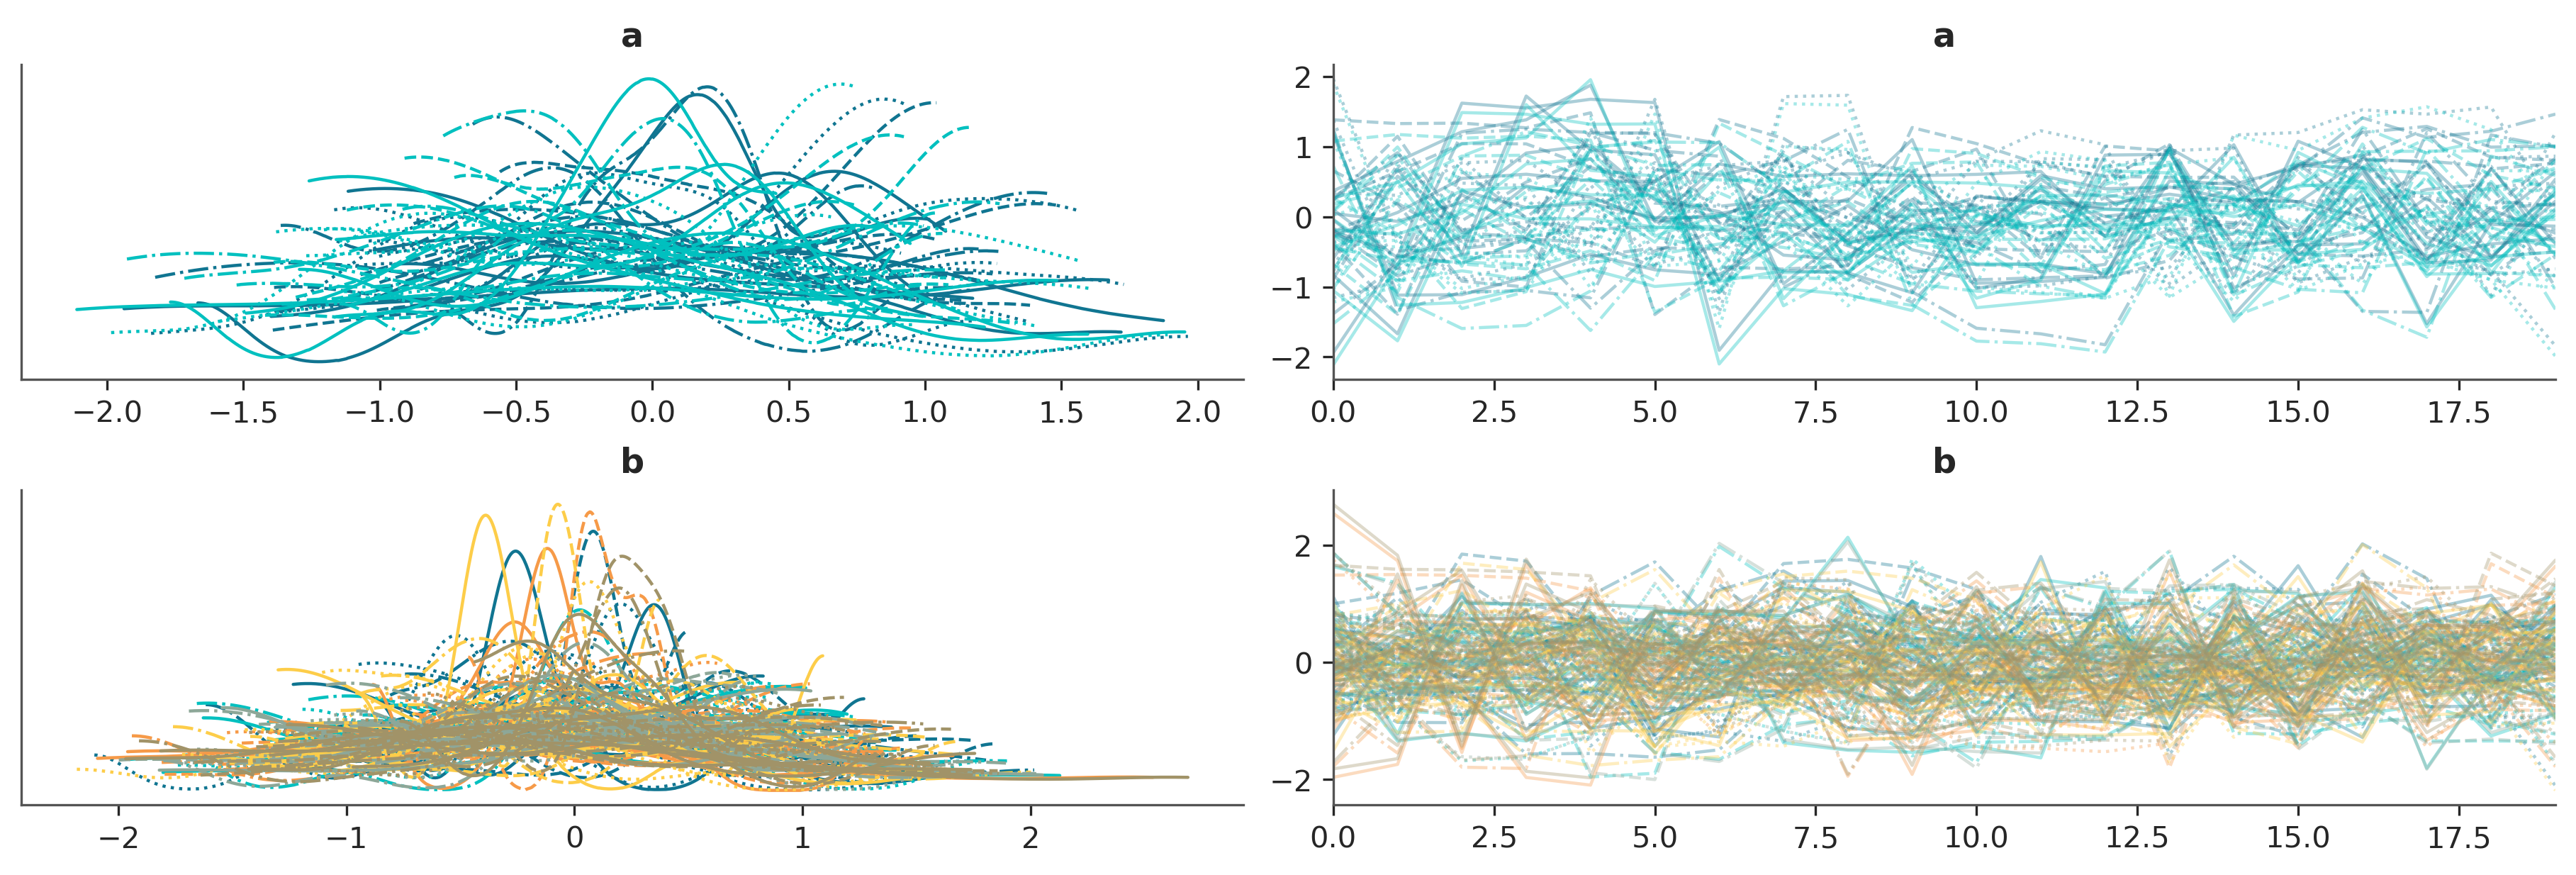

In [19]:
az.style.use("arviz-doc")

az.plot_trace(stan_data, var_names=["a", "b"])

plt.show()